In [1]:
"""
CSE 402 Final Project

Group 9

Khushi Vora
Joel Nataren
Sydney Gruczelak
Jared Singh Sekhon
Kofi Debrah
Ajuisiwon Azantilow

Instructions:

There a 5 different sections in this project.
If you wish to train the model again, uncomment section 4 and run the program.
If you only wish to see evaluation statistics for the most recent trained model then run the program without any changes.

"""

import torch
import time
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import shutil
import json

In [2]:
# ======================
# SECTION 1: Folder Splitting
# ======================
#region
zip_file = "Celebrity Faces Dataset.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("Celebrity Faces Dataset")

src_directory = "Celebrity Faces Dataset"

src_directory = os.path.join(src_directory,src_directory)
final_dictionary = {}

dst_dir = "all_folders"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

temp_dic = {}

for celebrity_folder in os.listdir(src_directory):
    if celebrity_folder == ".DS_Store" or celebrity_folder == "__MACOSX":
        continue
    celebrity_count = 1
    index = 1
    for img in os.listdir(os.path.join(src_directory, celebrity_folder)):
        if index == 11:
            index = 1
        folder_name = "folder" + str(index)
        dst = os.path.join(dst_dir, folder_name)
        src = os.path.join(src_directory, celebrity_folder)
        src = os.path.join(src, img)
        if not os.path.exists(dst):
            os.makedirs(dst)
        if folder_name not in temp_dic:
            temp_dic[folder_name] = {}
            temp_dic[folder_name][celebrity_folder] = 1
        else:
            if celebrity_folder not in temp_dic[folder_name]:
                temp_dic[folder_name][celebrity_folder] = 1
            else:
                temp_dic[folder_name][celebrity_folder] += 1
        if temp_dic[folder_name][celebrity_folder] <= 10:
            shutil.copy(src, dst)
        index += 1
        celebrity_count += 1
        final_dictionary[img] = celebrity_folder

with open("image_labels", "w") as fp:
    json.dump(final_dictionary , fp)
#endregion

In [3]:
# ======================
# SECTION 2: Image Preprocessing
# ======================
#region
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

class PreprocessedImg:
    """
    Image class for the project, automatically preprocesses data on initialization.
    Label attribute for keeping ground truths.
    Image attribute for reading in images and creating a tensor out of it.
    Tensor attribute for passing into a neural network.
    """
    def __init__(self, filename: str, label: str):
        """
        Initialization function
        :param filename: Image filename
        :param label: Image label
        """
        self.image = None                                           # Initialize Preprocessed image object
        self.label = label
        self.name = filename
        self.tensor = None

    def preprocess(self):                                           # Preprocessing step, done not on init
        """
        Preprocesses the image in this function instead of init to prevent repetitive preprocessing upon copying
        :return: None
        """
        self.image = Image.open(self.name)                          # Create image
        tensor = transform(self.image)                              # Transform image
        self.tensor = torch.unsqueeze(tensor, 0)               # Create tensor for image


all_folders_dir = "all_folders"                                         # Directory of the 10 folders

folder_master_list = []
labels_list = []
labels_set = set()

for folder in os.listdir(all_folders_dir):                              # Loop through all folders
    folder_list = []
    if folder != '.DS_Store':                                                  # Initialize a temp list of images for the fold
        for img in os.listdir(os.path.join(all_folders_dir, folder)):       # Loop through images and create preprocessedimg
            if ".jpg" not in img:                                           # Skip non-jpgs
                continue
            label = final_dictionary[img]
            if label not in labels_set:
                labels_list.append(label)
                labels_set.add(label)                              # Get Label and create image
            folderpath = os.path.join(all_folders_dir, folder)              # Folder path
            img_name = os.path.join(folderpath, img)                        # Full Image name
            image = PreprocessedImg(img_name, label)
            image.preprocess()                                              # Run preprocess function
            folder_list.append(image)                                       # Add to folder list of images
    folder_master_list.append(folder_list)

master_train = []                                                       # Master train list
master_test = []                                                        # Master test list

for i in range(10):                                                     # Loop 10 times

    temp_train = []                                                     # Initialize temp train and test sets
    temp_test = []

    for j in range(len(folder_master_list)):                            # Loop through Folders
        if j == i:                                                      # Add to test set if equal to current number
            temp_test.append(folder_master_list[j])
        else:
            temp_train.append(folder_master_list[j])                    # Add to train set if not

    master_test.append(temp_test)
    master_train.append(temp_train)
#endregion


In [4]:
# ======================
# SECTION 3: Define Neural Network
# ======================
#region
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
num_classes = 17  # Assuming 18 classes for your dataset
alexnet.classifier[6] = nn.Linear(4096, num_classes)

label_to_index = {label: index for index, label in enumerate(labels_list)}

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet.to(device)
#endregion


# ======================
# SECTION 4: Train Model
#
# Uncomment the section below to train the model.
# ======================
#region
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

# predictions = []
# labels = []
# num_epochs = 1

# for epoch in range(num_epochs):
#     for i in range(len(master_train)):
#         # Iterate over each folder in the training set
#         for img_obj in master_train[i]:
#             for image in img_obj:
#                 inputs, label_str = image.tensor.to(device), image.label

#                 label = torch.tensor([label_to_index[label_str]], dtype=torch.long)
#                 label = label.to(device)

#                 optimizer.zero_grad()
#                 outputs = alexnet(inputs)
#                 loss = criterion(outputs, label)
#                 loss.backward()
#                 optimizer.step()

#     alexnet.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for i in range(len(master_test)):
#             for img_obj in master_test[i]:
#                 for img in img_obj:
#                     inputs, label_str = img.tensor.to(device), img.label
#                     if label_str not in label_to_index:
#                         print("Label : {} not found in mapping".format(label_str))
#                         continue

#                     label = torch.tensor([label_to_index[label_str]], dtype=torch.long)
#                     label = label.to(device)
#                     labels.append(label)

#                     outputs = alexnet(inputs)
#                     _, predicted = torch.max(outputs.data, 1)
#                     predictions.append(predicted)
#                     total += label.size(0)
#                     print("predicted : ", predicted, "label : ", label)
#                     correct += (predicted == label).sum().item()

#         accuracy = correct / total
#         print("Average Recognition Accuracy using LOOCV Scheme: ", accuracy)
#         alexnet.train()

#         # Save the model state and accuracy in a dictionary
#         model_info = {
#             "model_state": alexnet.state_dict(),
#             "accuracy": accuracy
#         }

#         # Save the dictionary to a file
#         torch.save(model_info, 'model_and_accuracy.pth')
#endregion



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 121MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Average Recognition Accuracy using LOOCV Scheme:  0.973202614379085


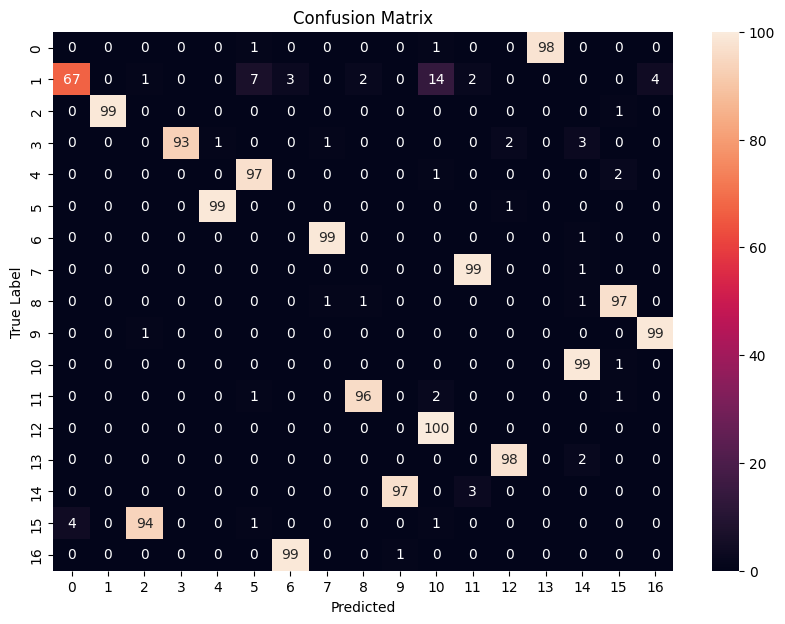

In [5]:
# ======================
# SECTION 5: Load Model & Evaluate
#
# This will load the saved model and show evaluation statistics
# ======================
#region

model_info = torch.load('model_and_accuracy.pth')
alexnet.load_state_dict(model_info["model_state"])
accuracy = model_info["accuracy"]

print("Average Recognition Accuracy using LOOCV Scheme: ", accuracy)

alexnet.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for test_set in master_test:
        for folder in test_set:
            for img_obj in folder:
                inputs, label_str = img_obj.tensor.to(device), img_obj.label
                label = torch.tensor([label_to_index[label_str]], dtype=torch.long)
                label = label.to(device)

                outputs = alexnet(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(label.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
#endregion